In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
#https://www.kaggle.com/datasets/cheneblanc/housing-prices-35-fr  -> lien dataset kaggle
# Kaggle Dataset vente appartements/maisons depuis 2014, mise a jour tous les 6 mois, date de téléchargement : 11/12/2025
data = pd.read_csv("housing-prices-35.csv")
data = data.drop(columns=['position_wgs', 'shape_wgs'], axis=1)
data.head()

,date,x_lbt93,y_lbt93,category,area_living,area_land,n_rooms,price
0,2020-09-16,352812.796362,6.788576e+06,C,30.0,0.0,1,120000.0
1,2020-08-05,359546.007545,6.793215e+06,C,67.0,0.0,3,176000.0
2,2020-01-06,341968.217653,6.843224e+06,H,56.0,2168.0,3,125000.0
3,2020-01-06,341968.217653,6.843224e+06,H,56.0,2168.0,3,125000.0
4,2020-05-19,395794.852753,6.819483e+06,H,32.0,891.0,1,13000.0


In [4]:
data.describe()

,x_lbt93,y_lbt93,area_living,area_land,n_rooms,price
count,148970.000000,1.489700e+05,148970.000000,148970.000000,148970.000000,1.489700e+05
mean,351220.814607,6.799297e+06,90.773491,3902.503987,3.796133,1.864430e+05
std,17883.646793,2.656395e+04,46.217385,21987.058542,1.664405,1.812097e+05
min,306756.599643,6.739270e+06,9.000000,0.000000,1.000000,1.000000e+00
25%,339076.610474,6.785766e+06,60.000000,0.000000,3.000000,1.029000e+05
50%,351102.793226,6.790577e+06,83.000000,467.000000,4.000000,1.560000e+05
75%,357636.268534,6.814929e+06,114.000000,1425.000000,5.000000,2.250000e+05
max,400278.238830,6.855731e+06,667.000000,492529.000000,32.000000,2.220000e+07


In [5]:
data.isnull().sum()

date           0
x_lbt93        0
y_lbt93        0
category       0
area_living    0
area_land      0
n_rooms        0
price          0
dtype: int64

Les données sont "propres" pas de données manquantes, une bonne chose


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148970 entries, 0 to 148969
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   date         148970 non-null  object 
 1   x_lbt93      148970 non-null  float64
 2   y_lbt93      148970 non-null  float64
 3   category     148970 non-null  object 
 4   area_living  148970 non-null  float64
 5   area_land    148970 non-null  float64
 6   n_rooms      148970 non-null  int64  
 7   price        148970 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 9.1+ MB


In [7]:
categorical_col = data.select_dtypes(include='object').columns.tolist()

for col in categorical_col:
    print(f"Col : {col} -> {data[col].unique()}")

Col : date -> ['2020-09-16' '2020-08-05' '2020-01-06' ... '2014-03-01' '2014-06-09'
 '2014-09-17']
Col : category -> ['C' 'H']


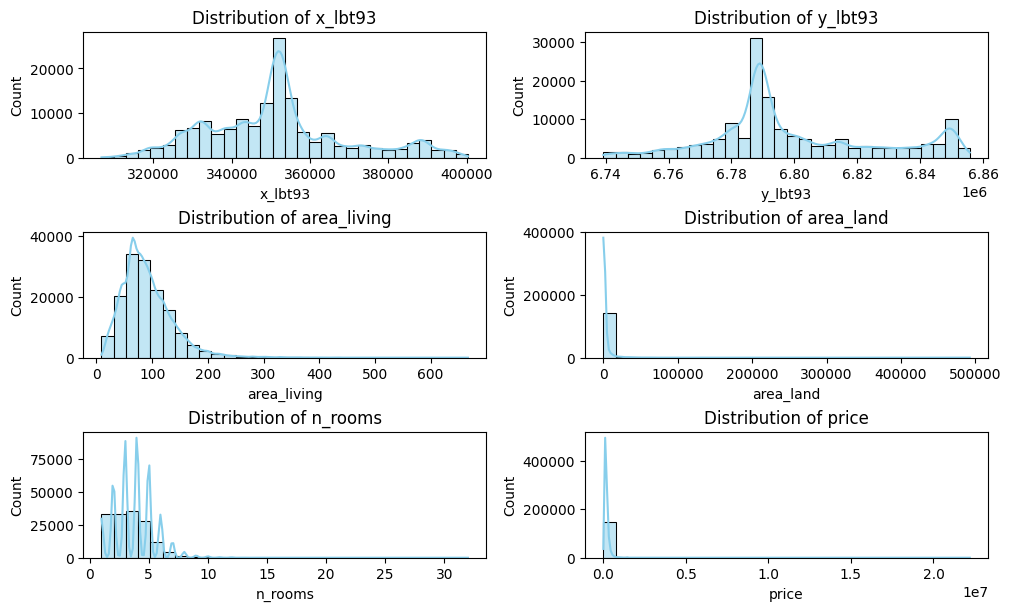

In [8]:
numerical_col = data.select_dtypes(include='number').columns.tolist()

fig, axs = plt.subplots(3, 2, figsize=(10, 6), constrained_layout=True)
for col, ax in zip(numerical_col, axs.flatten()):
    sns.histplot(data, x=col, bins=30, kde=True, color='skyblue', ax=ax)
    ax.set_title(f"Distribution of {col}")

plt.show()

Columns:
- area_land -> taille du terrain (si il y en a un)
- area_living -> mètres carrés habitables
- n_rooms -> nombre de pièces de vie (salon/séjour, salle à manger, chambres, bureau)
- category -> appartement ou maison
- x_lbt93 -> coordonnées x lambert 93
- y_lbt93 -> coordonnées y lambert 93
- data -> date de vente

<Axes: >

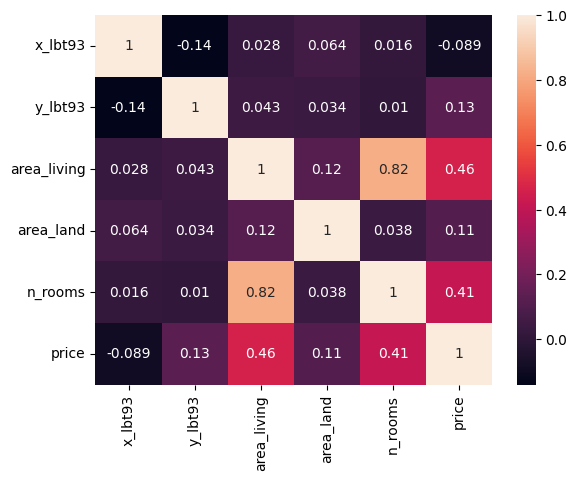

In [9]:
sns.heatmap(data[numerical_col].corr(), annot=True)

<Axes: xlabel='price', ylabel='Count'>

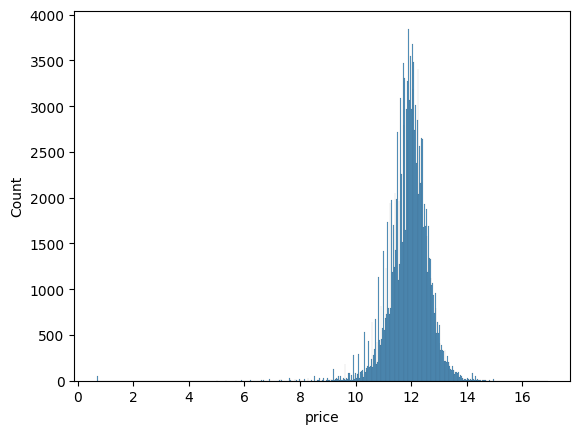

In [10]:
sns.histplot(np.log1p(data['price']))

<Axes: xlabel='area_living', ylabel='price'>

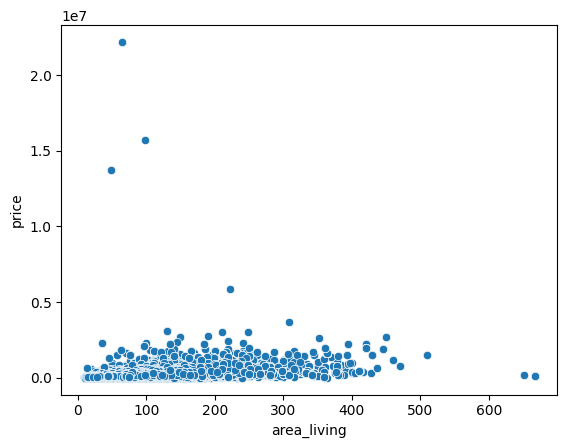

In [11]:
sns.scatterplot(x=data['area_living'], y=data['price'], data=data)

Ici on remarque trois outliers, un a environ 20 000 000€ pour $100m^2$ et deux autres à plus de 600$m^2$. Nous allons donc les supprimer, pour éviter d'entrainer un modèle sur des valeurs aberrantes.

In [12]:
bizarreries = data[ (data['area_living'] > 400) | (data['price'] > 2000000) ]
print(bizarreries[['area_living', 'price', 'n_rooms']])

        area_living       price  n_rooms
510            48.0  13750000.0        2
511            48.0  13750000.0        2
4787           65.0  22200000.0        3
4788           65.0  22200000.0        3
7969           36.0   2293897.2        1
...             ...         ...      ...
145684         98.0  15700000.0        5
147703        445.0   1900000.0        7
147704        445.0   1900000.0        7
147705        445.0   1900000.0        7
147706        445.0   1900000.0        7

[158 rows x 3 columns]


Ici on remarque bien les incohérences des outliers, exemple -> $667m^2$ habitable mais seulement 2 pièces et un prix a 115K€, il y a du avoir des erreurs de frappes. Pareil pour l'appartement a 22M€ pour $65m^2$.
On va aussi nettoyer les éventuelles erreurs de prix a 1€ (minimum 10K€) et $9m^2$.

<Axes: xlabel='area_living', ylabel='price'>

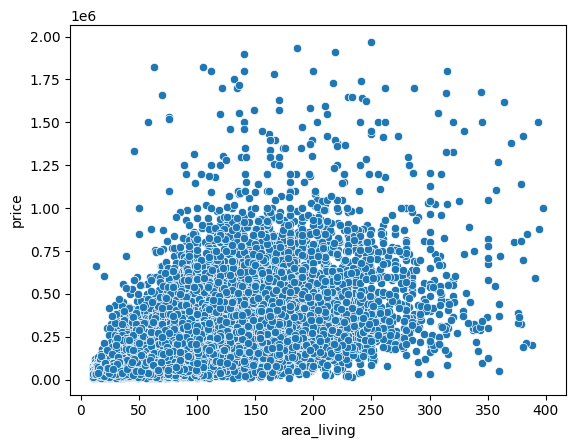

In [13]:
filtre_prix =(data['price'] > 10000) & (data['price'] < 2000000)
filtre_taille = (data['area_living'] > 9) & (data['area_living'] < 400)

data_clean = data[filtre_prix & filtre_taille].copy()
data_clean = data_clean.drop_duplicates()
sns.scatterplot(x=data_clean['area_living'], y=data_clean['price'], data=data_clean)

Voici donc une bien meilleure répartition des prix par rapport aux mètres carrés habitables grâce aux filtres appliqués.

In [14]:
print(f"Lignes supprimées : {len(data) - len(data_clean)}")

Lignes supprimées : 52694


In [15]:
data_clean[numerical_col].describe()

,x_lbt93,y_lbt93,area_living,area_land,n_rooms,price
count,96276.000000,9.627600e+04,96276.000000,96276.000000,96276.000000,9.627600e+04
mean,350731.561566,6.798919e+06,86.073414,1130.376854,3.751641,1.843399e+05
std,16933.405091,2.608241e+04,41.481064,6963.804082,1.609826,1.262678e+05
min,306756.599643,6.739270e+06,10.000000,0.000000,1.000000,1.020000e+04
25%,339477.526160,6.786200e+06,59.000000,0.000000,3.000000,1.060000e+05
50%,351110.473879,6.789998e+06,80.000000,277.000000,4.000000,1.580000e+05
75%,356173.764512,6.812327e+06,109.000000,691.000000,5.000000,2.270000e+05
max,400278.238830,6.855731e+06,398.000000,492529.000000,32.000000,1.970000e+06


Maintenant on va passer à la partie feature engineering.

In [16]:
def data_featuring(df):
    rennes_x = 352500
    rennes_y = 6789000 #Coordonnées approximative centre (mairie) de Rennes
    stM_x = 337500
    stM_y = 6850000 #coordonnées approximative centre (Mairie) st-Malo

    #Pythagore sqrt((x2-x1)^2 + (y2 - y1)^2)
    df['d_rennes'] = (np.sqrt((df['x_lbt93'] - rennes_x)**2 + (df['y_lbt93'] - rennes_y)**2))/1000
    df['d_st_malo'] = (np.sqrt((df['x_lbt93'] - stM_x)**2 + (df['y_lbt93'] - stM_y)**2))/1000
    # distances en kilomètres

    mapping_category = {'C': 'Condo', 'H': 'House'} # après cela va devenir colones 0/1 avec OnehotEncoder
    df = df.replace(mapping_category)

    df['date_mutation'] = pd.to_datetime(df['date'])
    df['annee_vente'] = df['date_mutation'].dt.year
    df['mois_vente'] = df['date_mutation'].dt.month

    df['taille_moyenne_piece'] = df['area_living']/df['n_rooms']
    df['densite_jardin'] = df['area_living']/(df['area_land'] + 1)

    df = df.drop(columns=['date', 'date_mutation'], axis=1)
    
    return df

new_data = data_featuring(data_clean)
new_data
    

,x_lbt93,y_lbt93,category,area_living,area_land,n_rooms,price,d_rennes,d_st_malo,annee_vente,mois_vente,taille_moyenne_piece,densite_jardin
0,352812.796362,6.788576e+06,Condo,30.0,0.0,1,120000.0,0.526903,63.303957,2020,9,30.000000,30.000000
1,359546.007545,6.793215e+06,Condo,67.0,0.0,3,176000.0,8.210284,60.914795,2020,8,22.333333,67.000000
2,341968.217653,6.843224e+06,House,56.0,2168.0,3,125000.0,55.236996,8.116865,2020,1,18.666667,0.025818
4,395794.852753,6.819483e+06,House,32.0,891.0,1,13000.0,52.949683,65.799436,2020,5,32.000000,0.035874
6,370011.553386,6.822364e+06,House,107.0,3004.0,4,135000.0,37.680005,42.670516,2020,1,26.750000,0.035607
...,...,...,...,...,...,...,...,...,...,...,...,...,...
148963,331127.695624,6.768754e+06,House,164.0,1900.0,7,185000.0,29.439314,81.495447,2014,11,23.428571,0.086270
148964,354616.523560,6.789716e+06,Condo,28.0,0.0,1,64000.0,2.234253,62.667163,2014,8,28.000000,28.000000
148965,354951.540436,6.806547e+06,House,71.0,197.0,3,150000.0,17.717386,46.826522,2014,5,23.666667,0.358586
148966,352601.000568,6.788064e+06,Condo,76.0,0.0,5,160000.0,0.941384,63.750311,2014,8,15.200000,76.000000


In [17]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_validate

models = {
    'Regression': LinearRegression(),
    'GB': GradientBoostingRegressor(random_state=1),
    'RF': RandomForestRegressor(random_state=1),
    'DT': DecisionTreeRegressor(random_state=1)
}

X = new_data.drop(columns=['price'], axis=1)
y = new_data.price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, train_size=0.75)

num_col = X.select_dtypes(include='number').columns.tolist()
cat_col = X.drop(columns=num_col, axis=1).columns.tolist()

num_pipe = Pipeline(steps=[
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline(steps=[
    ('oneHot', OneHotEncoder())
])

preprocessor = ColumnTransformer([
    ('numerical', num_pipe, num_col),
    ('categorical', cat_pipe, cat_col)
])

In [16]:

result = []

print("Starting training")
for name, model in models.items():
    pipe = make_pipeline(preprocessor, model)

    cv_results = cross_validate(pipe, X_train, y_train, cv=5, scoring='r2', return_train_score=True)
    result.append({
        'Model': name,
        'Mean_r2': np.mean(cv_results['test_score']),
        'Mean_train_time': np.mean(cv_results['fit_time'])
    })
    print(f"{name} -> scores : {cv_results['test_score']}\ndone.")

df_r = pd.DataFrame(result).sort_values(by='Mean_r2')
df_r

Starting training
Regression -> scores : [0.44050055 0.45705776 0.44937651 0.46561068 0.4601451 ]
done.
GB -> scores : [0.6937448  0.69319198 0.69500242 0.70744051 0.71536568]
done.
RF -> scores : [0.73773633 0.72461756 0.73980479 0.74915432 0.75401385]
done.
DT -> scores : [0.50405866 0.41367062 0.48349853 0.50050673 0.47729755]
done.


,Model,Mean_r2,Mean_train_time
0,Regression,0.454538,0.064694
3,DT,0.475806,0.958969
1,GB,0.700949,14.705766
2,RF,0.741065,55.181640


Ici on remaque que les deux meilleurs models sont Gradient Bootsing et RandomForest, ils sont tous les deux aux alentours de 70% de score, on va donc les réutiliser pour essayer d'améliorerleur scores : premièrement en passant le prix en log1p grâce a numpy.

In [17]:
final_models = {
    'GB': GradientBoostingRegressor(random_state=1),
    'RF': RandomForestRegressor(random_state=1),
}

y_train_log = np.log1p(y_train)

print("--- Test avec Logarithme du Prix ---")

for name, model in final_models.items(): # Correction du 's' ici
    pipe = make_pipeline(preprocessor, model)

    # On utilise y_train_log ici
    cv_results = cross_validate(pipe, X_train, y_train_log, cv=5, scoring='r2', return_train_score=True)
    
    mean_score = np.mean(cv_results['test_score'])
    std_score = np.std(cv_results['test_score'])
    
    print(f"{name} -> R2 (Log) : {mean_score:.4f} (+/- {std_score:.4f})")
    print(f"Scores bruts : {cv_results['test_score']}")
    print("-" * 30)

print("Done.")

--- Test avec Logarithme du Prix ---
GB -> R2 (Log) : 0.6863 (+/- 0.0074)
Scores bruts : [0.68691249 0.67378779 0.68463992 0.68995602 0.6963111 ]
------------------------------
RF -> R2 (Log) : 0.7187 (+/- 0.0069)
Scores bruts : [0.7166839  0.70740417 0.72261934 0.71825256 0.72834406]
------------------------------
Done.


Ici on constate donc, qu'en utilisant le logarithme ($ln(1+x)$) on arrive a un score moyen inférieur, même si l'écart-type est aussi inférieur de 0.002 environ, le modèle avec le prix de base en K€ est plus performant (même dans ses mauvais jours).
On va donc garder le premier test de model.

In [21]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

param_grid = {
    'randomforestregressor__n_estimators':[100, 200, 300],
    'randomforestregressor__max_depth':[None, 10, 20, 30],
    'randomforestregressor__min_samples_split':[2, 5, 10],
    'randomforestregressor__min_samples_leaf': [1, 2, 4]    
}

pipe_rf = make_pipeline(preprocessor, rf)

print("Recherche des meilleurs hyperparamètres en cours...")
search = RandomizedSearchCV(
    pipe_rf, 
    param_distributions=param_grid, 
    n_iter=20,
    cv=3,
    scoring='r2',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train, y_train)

print(f"---RESULTATS---\nMeilleur score trouvé : {search.best_score_:.4f}\nMeilleurs paramètres : {search.best_params_}")

Recherche des meilleurs hyperparamètres en cours...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
---RESULTATS---
Meilleur score trouvé : 0.7405
Meilleurs paramètres : {'randomforestregressor__n_estimators': 300, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__max_depth': None}


In [31]:
import joblib
from sklearn.metrics import r2_score, mean_absolute_error

final_rf = search.best_estimator_
y_pred = final_rf.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(r2_score(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))

print(f"🎯 Précision (MAPE)     : {mape:.2%}")
joblib.dump(final_rf, 'modele_immo.pkl')

0.7479617330439396
36416.060873681854
🎯 Précision (MAPE)     : 26.33%


['modele_immo.pkl']

Conclusion, au final on trouve un score $R^2$ de 74.8%, une erreur absolue de $\approx 36416$€ et une MAPE de 26.33%.
On peut donc dire que qu'un score d'environ 75% est plutôt performant, pour un estimation réalisée sur tout un département, qui regroupe donc de parties comme, dans nôtre cas Rennes et St-Malo qui ont des prix bien plus élevées que certaines petits bien dans des communes plus rurales, c'est en partie a cause de ça que la MAPE est un peu élevée.
Mais au global, en valeur absolue, pour un bien de 300 000€, on aura une estimation entre 264K€ et 336K€.

In [32]:
list(X_train.columns)

['x_lbt93',
 'y_lbt93',
 'category',
 'area_living',
 'area_land',
 'n_rooms',
 'd_rennes',
 'd_st_malo',
 'annee_vente',
 'mois_vente',
 'taille_moyenne_piece',
 'densite_jardin']

In [22]:
import joblib
from sklearn.ensemble import RandomForestRegressor

# On reprend tes meilleurs paramètres, MAIS on limite la profondeur
# C'est 'max_depth' et 'min_samples_leaf' qui contrôlent la taille du fichier
final_rf_light = RandomForestRegressor(
    n_estimators=100,       # 100 arbres suffisent souvent
    max_depth=15,           # <--- CRUCIAL : On empêche l'arbre d'aller à l'infini
    min_samples_leaf=5,     # <--- CRUCIAL : On ne garde pas les feuilles uniques
    random_state=42,
    n_jobs=-1
)

pipe_rf = make_pipeline(preprocessor, final_rf_light)
print("Entraînement du modèle allégé...")
pipe_rf.fit(X_train, y_train)
# --- SAUVEGARDE COMPRESSÉE ---
print("Sauvegarde...")
# compress=3 permet de diviser la taille par 5 ou 10 !
joblib.dump(final_rf_light, 'modele_immo.pkl', compress=3) 

print("✅ Terminé ! Vérifie la taille du fichier 'modele_immo.pkl' maintenant.")
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

# 1. Charge le modèle léger

# 2. Fais une prédiction sur le Test Set (le même qu'avant)
# Attention : Assure-toi que X_test et y_test sont bien définis dans ta mémoire
y_pred_light = pipe_rf.predict(X_test)

# 3. Calcule la MAPE
# (Rappel: si tu n'as pas utilisé de Log, pas besoin de np.expm1)
mape_light = mean_absolute_percentage_error(y_test, y_pred_light)

print(f"MAPE du modèle léger : {mape_light:.2%}")

Entraînement du modèle allégé...
Sauvegarde...
✅ Terminé ! Vérifie la taille du fichier 'modele_immo.pkl' maintenant.


In [21]:
import joblib
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

# 1. Charge le modèle léger
model_light = joblib.load('modele_immo.pkl')

# 2. Fais une prédiction sur le Test Set (le même qu'avant)
# Attention : Assure-toi que X_test et y_test sont bien définis dans ta mémoire
y_pred_light = model_light.predict(X_test)

# 3. Calcule la MAPE
# (Rappel: si tu n'as pas utilisé de Log, pas besoin de np.expm1)
mape_light = mean_absolute_percentage_error(y_test, y_pred_light)

print(f"MAPE du modèle léger : {mape_light:.2%}")

C:\Users\matte\OneDrive\Documents\Coding\modelEstimateurInteractif\.venv\Lib\site-packages\sklearn\utils\validation.py:2684: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


ValueError: could not convert string to float: 'House'